Loaded 240 images of class CHEETAH
Loaded 238 images of class OCELOT
Loaded 190 images of class CARACAL
Loaded 233 images of class LIONS
Loaded 242 images of class TIGER
Loaded 241 images of class PUMA
Loaded 1384 images total.
x shape: (1384, 224, 224, 3), y shape:(1384,)


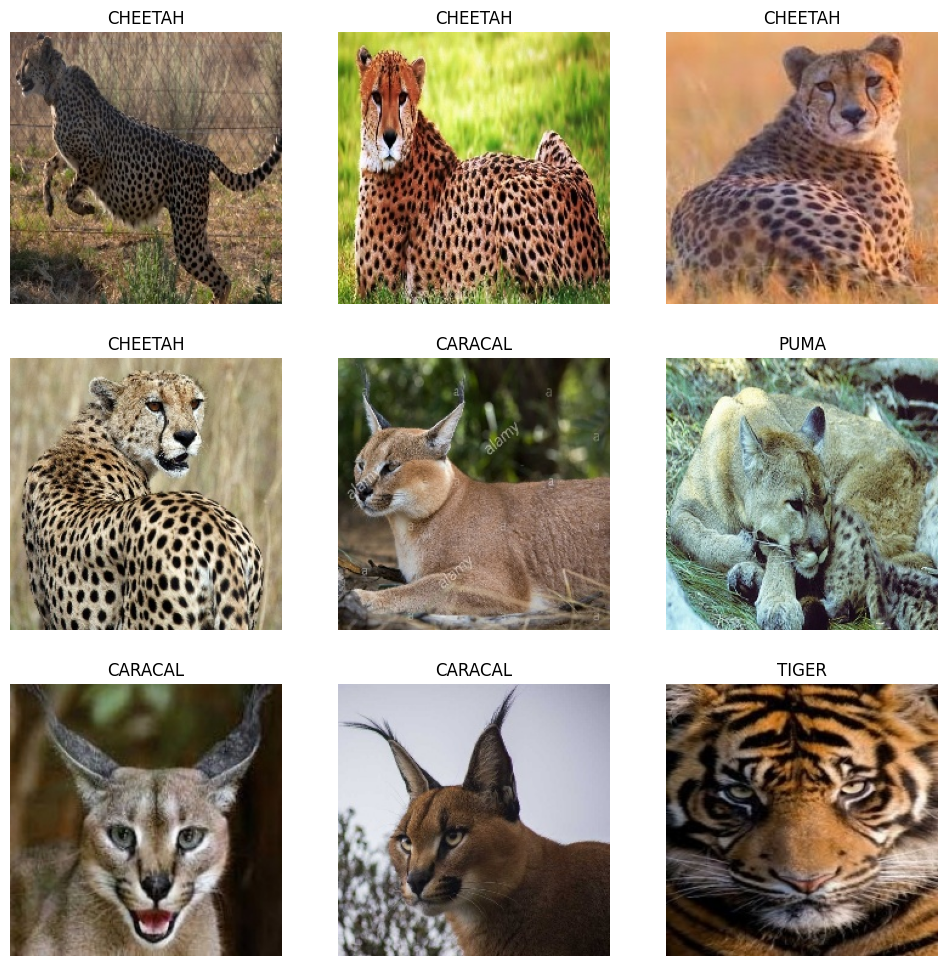

In [60]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

def load_imgs(path, folders):
    imgs = []
    labels = []
    n_imgs = 0
    for c in folders:
        # iterate over all the files in the folder
        for f in os.listdir(os.path.join(path, c).replace("/mnt/z", 'Z:\\')):
            if not f.endswith('.jpg'):
                continue
            # load the image (here you might want to resize the img to save memory)
            im = Image.open(os.path.join(path, c, f)).copy()
            imgs.append(im)
            labels.append(c)
        print('Loaded {} images of class {}'.format(len(imgs) - n_imgs, c))
        n_imgs = len(imgs)
    print('Loaded {} images total.'.format(n_imgs))
    return imgs, labels

def plot_sample(imgs, labels, nrows=4, ncols=4, resize=None):
    # create a grid of images
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    # take a random sample of images
    indices = np.random.choice(len(imgs), size=nrows*ncols, replace=False)
    for ax, idx in zip(axs.reshape(-1), indices):
        ax.axis('off')
        # sample an image
        ax.set_title(labels[idx])
        im = imgs[idx]
        if isinstance(im, np.ndarray):
            im = Image.fromarray(im)  
        if resize is not None:
            im = im.resize(resize)
        ax.imshow(im, cmap='gray')


# map class -> idx
label_to_idx = {
    'CHEETAH':0,
    'OCELOT': 1,
    'CARACAL':2,
    'LIONS': 3,
    'TIGER':4,
    'PUMA':5
}

idx_to_label = {
    0:'CHEETAH',
    1:'OCELOT',
    2:'CARACAL',
    3:'LIONS',
    4:'TIGER',
    5: 'PUMA'
}

def make_dataset(imgs, labels, label_map, img_size):
    x = []
    y = []
    n_classes = len(list(label_map.keys()))
    for im, l in zip(imgs, labels):
        # preprocess img
        x_i = im.resize(img_size)
        x_i = np.asarray(x_i)
        
        # encode label
        y_i = label_map[l]
        
        x.append(x_i)
        y.append(y_i)
    return np.array(x).astype('float32'), np.array(y)

def save_model(model, filepath):
    """
    Save PyTorch model to a file.

    Args:
        model: PyTorch model to be saved.
        filepath (str): Path to save the model.
    """
    torch.save(model.state_dict(), filepath)

def load_model(model_class, filepath, device='cpu'):
    """
    Load PyTorch model from a file.

    Args:
        model_class: Model class (e.g., ConvNet) to instantiate.
        filepath (str): Path from which to load the model.
        device (str): Device to move the model to (default is 'cpu').

    Returns:
        model: Loaded PyTorch model.
    """
    model = model_class() # change it to your own model class
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    return model

# Create new Dataset objects for the training and test datasets
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            if isinstance(x, np.ndarray):
                #print("s1", x.shape)
                #x = x.transpose(1, 2, 0)
                x = torch.tensor(x)
                #print("s2", x.shape, x.dtype)
                x = transforms.functional.to_pil_image(x)
            x = self.transform(x)
            x = x.numpy()
        return x, y

    def __len__(self):
        return len(self.data)


imgs, labels = load_imgs('/kaggle/input/dataset1/Dataset', ['CHEETAH' ,'OCELOT', 'CARACAL', 'LIONS', 'TIGER', 'PUMA']) #TODO CHANGE ME!!
X, y = make_dataset(imgs, labels, label_to_idx, (224,224))
print('x shape: {}, y shape:{}'.format(X.shape, y.shape))
plot_sample(imgs, labels, 3, 3, resize=(224, 224))

cuda
Epoch [1/101], Train Acc: 19.87, Val Acc: 25.36
Epoch [11/101], Train Acc: 47.88, Val Acc: 28.99
Epoch [21/101], Train Acc: 72.99, Val Acc: 39.86
Epoch [31/101], Train Acc: 85.37, Val Acc: 34.78
Epoch [41/101], Train Acc: 98.92, Val Acc: 38.41
Epoch [51/101], Train Acc: 77.51, Val Acc: 32.61
Epoch [61/101], Train Acc: 99.91, Val Acc: 37.68
Epoch [71/101], Train Acc: 100.00, Val Acc: 33.33
Epoch [81/101], Train Acc: 100.00, Val Acc: 34.06
Epoch [91/101], Train Acc: 100.00, Val Acc: 34.06
Epoch [101/101], Train Acc: 100.00, Val Acc: 33.33
Best accuracy: 39.86


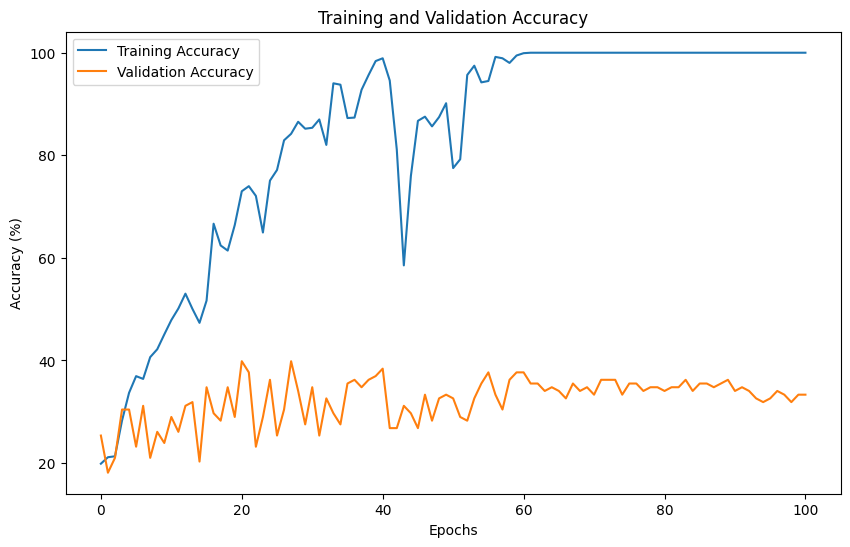

Test Accuracy: 38.13%
Test Loss averaged: 1.8997
Accuracy Variance: 209.8851



In [61]:
################### Task 1 ###################
import copy
from torch import nn
from torch.nn import functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# general context setting
CONFIGS = {
    'seed': 20020309, 
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
    'batch_size': 32,
    'epochs': 1 + 100, # 100 
    'learning_rate':  0.001,
    'ratio': {'train': 0.8, 'val': 0.5}, # implicit test set = 10% of whole dataset
    'optimizer': lambda model_params: torch.optim.Adam(model_params, lr=CONFIGS['learning_rate']),
    'criterion': nn.CrossEntropyLoss() # fits classification task with discrete values
}

np.random.seed(CONFIGS['seed'])
torch.manual_seed(CONFIGS['seed'])
print(CONFIGS['device'])


class FFNN(nn.Module):
    def __init__(self, _in_features, _num_classes):
        super(FFNN, self).__init__()
        # 3 layers
        self.fc1 = nn.Linear(_in_features, 128)  # input layer with 128 hidden units
        self.fc2 = nn.Linear(128, 64)  # hidden layer with 64 hidden units
        self.fc3 = nn.Linear(64, _num_classes)  # output layer with num_classes units

    def forward(self, _x):
        # pass through layers with GELU activation
        _x = F.gelu(self.fc1(_x))
        _x = F.gelu(self.fc2(_x))
        _x = self.fc3(_x) # no activation for the output layer, output raw logits
        return _x


def get_input(_f_features=None, _permute=False):
    """_f_features is a function"""
    def safe_copy(*args):
        return map(lambda el: el.copy(), *args)
    
    _x, _y = safe_copy(make_dataset(imgs, labels, label_to_idx, (224,224))) # from init given cell
    _x = _x / 255.0 # normalizing images
    _feats = None
    if _f_features is not None:
        _feats = _f_features(_x)
        
    if _permute:
        _x = _x.transpose(0, 3, 1, 2)
    else: 
        _x = _x.reshape(_x.shape[0], -1) # 1D vector image flattened
        
    _encoder = OneHotEncoder(sparse_output=False, categories="auto")
    _y = _encoder.fit_transform(_y.reshape(-1, 1))
    return _x, _y, _feats 


def get_loads(_x, _y, _transform=None, _ratio=CONFIGS['ratio'],  _batch_size=CONFIGS["batch_size"]):
    """
    _ratio: dict with keys 'train', 'val' and values in [0, 1]
    """
    _data = [(_x[i], _y[i]) for i in range(len(_x))] # to use provided Dataset class
    _train_data, _val_test_data = train_test_split(
        _data, train_size=_ratio['train'], random_state=CONFIGS['seed']
    )
    # split validation data into validation and test data
    _val_data, _test_data = train_test_split(
        _val_test_data, train_size=_ratio['val'], random_state=CONFIGS['seed']
    )
    # prepare data for training DataLoader
    _train_dataset = Dataset(_train_data, transform=_transform) # transform only on training data
    _val_dataset = Dataset(_val_data)
    _test_dataset = Dataset(_test_data)
    # create dataLoader for both training and test datasets
    _train_loader = DataLoader(_train_dataset, batch_size=_batch_size, shuffle=True)
    _val_loader = DataLoader(_val_dataset, batch_size=_batch_size, shuffle=True)
    _test_loader = DataLoader(_test_dataset, batch_size=_batch_size, shuffle=True)
    return _train_loader, _val_loader, _test_loader


def calculate_accuracy(_y_true, _y_pred):
    _predicted_classes = torch.argmax(_y_pred, dim=1)
    _true_classes = torch.argmax(_y_true, dim=1)
    _correct = (_predicted_classes == _true_classes).sum().item()
    return _correct


def load_to_device(*args):
    return map(lambda el: el.to(CONFIGS["device"]), args)


def plot_accuracies(_train_acc, _val_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(_train_acc, label='Training Accuracy')
    plt.plot(_val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    

class TestMetrics():
    def __init__(self, _acc, _loss, _var, _batch_accs):
        self.accuracy = _acc
        self.loss_avg = _loss
        self.accuracy_var = _var
        self.batch_accuracies = _batch_accs
        
    def __str__(self):
        return (
            f"Test Accuracy: {self.accuracy:.2f}%\n" +
            f"Test Loss averaged: {self.loss_avg:.4f}\n" + 
            f"Accuracy Variance: {self.accuracy_var:.4f}\n"
        )

    def __repr__(self):
        return self.__str__()


def evaluate_model(_model, _test_loader, _criterion=CONFIGS['criterion']):
    _test_correct = 0
    _test_total = 0
    _test_loss = 0.0
    _batch_accuracies = []

    with torch.no_grad():
        for _inputs, _labels in _test_loader:
            _inputs, _labels = load_to_device(_inputs, _labels)
            _outputs = _model(_inputs)
            _loss = _criterion(_outputs, _labels.float())
            _test_loss += _loss.item()
            _batch_correct = calculate_accuracy(_labels, _outputs)
            _batch_accuracy = 100 * _batch_correct / _labels.size(0)
            _batch_accuracies.append(_batch_accuracy)
            _test_correct += _batch_correct
            _test_total += _labels.size(0)

    _test_accuracy = 100 * _test_correct / _test_total
    _test_loss /= len(_test_loader)  # Average loss
    _accuracy_variance = np.var(_batch_accuracies)
    _metrics = TestMetrics(_test_accuracy, _test_loss, _accuracy_variance, _batch_accuracies)
    print(_metrics)
    return _metrics


def statistical_comparison(_metrics1, _metrics2):
    _t_stat, _p_value = ttest_rel(_metrics1.batch_accuracies, _metrics2.batch_accuracies)
    print(f"T-statistic: {_t_stat}, P-value: {_p_value}")
    # p val threshold for interpretation of result
    difference = False
    if _p_value < 0.05:
        print("THERE IS a statistically significant difference.")
        difference = True
    else:
        print("THERE IS **NO** statistically significant difference.")
    return difference

    
def train(_model, _criterion, _optimizer, _loaders, _epochs=CONFIGS["epochs"]):
    _train_loader, _val_loader = _loaders
    # train the model and get accuracies
    _train_acc = []
    _val_acc = []
    _best_val_accuracy = 0
    _best_model = None
    for _epoch in range(_epochs):
        _model.train()
        _running_loss = 0
        _correct = 0
        _total = 0
        for _inputs, _labels in _train_loader:
            _inputs, _labels = load_to_device(_inputs, _labels)
            _optimizer.zero_grad()
            _outputs = _model(_inputs)
            _loss = _criterion(_outputs, _labels.float())
            _loss.backward()
            _optimizer.step()
            _running_loss += _loss.item()
            # compute accuracy
            _correct += calculate_accuracy(_labels, _outputs)
            _total += _labels.size(0)
            
        _train_accuracy = 100 * _correct / _total
        _train_acc.append(_train_accuracy)

        # validation
        _model.eval()
        _val_correct = 0
        _val_total = 0
        with torch.no_grad():
            for _inputs, _labels in _val_loader:
                _inputs, _labels = load_to_device(_inputs, _labels)
                _outputs = _model(_inputs)
                _val_correct += calculate_accuracy(_labels, _outputs)
                _val_total += _labels.size(0)
                
        _val_accuracy = 100 * _val_correct / _val_total
        _val_acc.append(_val_accuracy)
        if _val_accuracy > _best_val_accuracy:
            _best_val_accuracy = _val_accuracy
            # Save best model
            _best_model = copy.deepcopy(_model)

        if _epoch % 10 == 0:
            print(f"Epoch [{_epoch+1}/{CONFIGS['epochs']}]", 
                  f"Train Acc: {_train_accuracy:.2f}",
                  f"Val Acc: {_val_accuracy:.2f}",
                  sep=", ")
            
    print(f"Best accuracy: {_best_val_accuracy:.2f}")
    return _train_acc, _val_acc, _best_model


x, y, _ = get_input()
train_loader, val_loader, test_loader = get_loads(_x=x, _y=y)
model_ffnn = FFNN(x.shape[1], len(label_to_idx)).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model_ffnn.parameters())
train_acc, val_acc, best_model_ffnn = train(
    model_ffnn, CONFIGS["criterion"], optimizer, (train_loader, val_loader)
)
save_model(best_model_ffnn, 'best_ffnn.pth')
plot_accuracies(train_acc, val_acc)
metrics_ffnn = evaluate_model(best_model_ffnn, test_loader)

Epoch [1/101], Train Acc: 19.15, Val Acc: 20.29
Epoch [11/101], Train Acc: 30.80, Val Acc: 21.01
Epoch [21/101], Train Acc: 31.89, Val Acc: 21.74
Epoch [31/101], Train Acc: 32.34, Val Acc: 25.36
Epoch [41/101], Train Acc: 31.71, Val Acc: 29.71
Epoch [51/101], Train Acc: 33.60, Val Acc: 23.91
Epoch [61/101], Train Acc: 33.51, Val Acc: 31.16
Epoch [71/101], Train Acc: 34.24, Val Acc: 26.81
Epoch [81/101], Train Acc: 34.06, Val Acc: 29.71
Epoch [91/101], Train Acc: 34.96, Val Acc: 29.71
Epoch [101/101], Train Acc: 35.41, Val Acc: 26.09
Best accuracy: 32.61


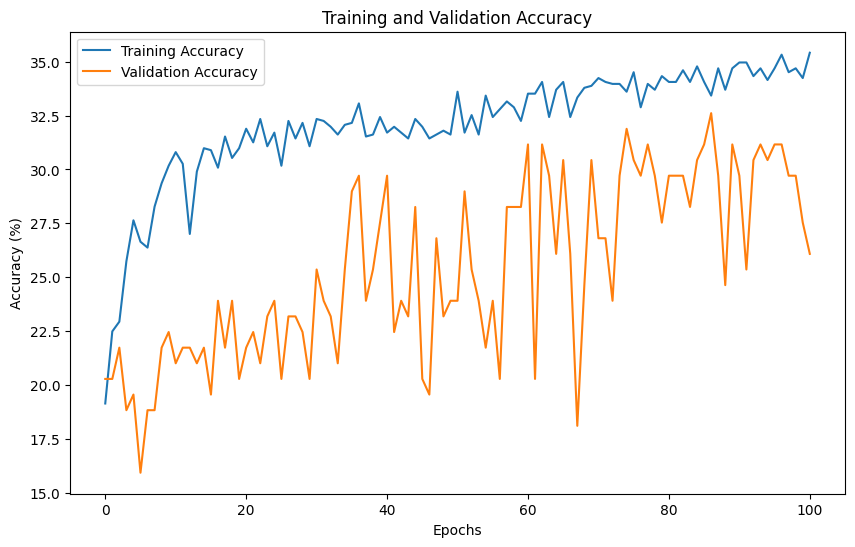

Test Accuracy: 35.25%
Test Loss averaged: 1.5792
Accuracy Variance: 36.8543

T-statistic: -0.1525452559514337, P-value: 0.8861423373577941
THERE IS **NO** statistically significant difference.


False

In [62]:
################### Task 1 BONUS ###################
def get_features(_imgs):
    _feats = []
    _r, _g, _b = 0, 1, 2
    get_mean_var = lambda img, idx : (np.mean(img[:,:,idx]), np.var(img[:,:,idx]))
    for _img in _imgs:
        _r_mean_var = get_mean_var(_img, _r)
        _g_mean_var = get_mean_var(_img, _g)
        _b_mean_var = get_mean_var(_img, _b)
        _feats.append([*_r_mean_var, *_g_mean_var, *_b_mean_var])
    return np.array(_feats)


_, y, feats = get_input(_f_features=get_features)
train_loader, val_loader, test_loader = get_loads(_x=feats, _y=y)
model_ffnn_feats = FFNN(feats.shape[1], len(label_to_idx)).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model_ffnn_feats.parameters())
train_acc, val_acc, best_model_ffnn_feats = train(
    model_ffnn_feats, CONFIGS["criterion"], optimizer, (train_loader, val_loader)
)
save_model(best_model_ffnn_feats, 'best_ffnn_feats.pth')
plot_accuracies(train_acc, val_acc)
metrics_ffnn_aug = evaluate_model(best_model_ffnn_feats, test_loader)
statistical_comparison(metrics_ffnn, metrics_ffnn_aug)

Epoch [1/101], Train Acc: 19.15, Val Acc: 13.04
Epoch [11/101], Train Acc: 98.92, Val Acc: 61.59
Epoch [21/101], Train Acc: 100.00, Val Acc: 68.12
Epoch [31/101], Train Acc: 100.00, Val Acc: 67.39
Epoch [41/101], Train Acc: 100.00, Val Acc: 67.39
Epoch [51/101], Train Acc: 100.00, Val Acc: 67.39
Epoch [61/101], Train Acc: 100.00, Val Acc: 67.39
Epoch [71/101], Train Acc: 100.00, Val Acc: 67.39
Epoch [81/101], Train Acc: 100.00, Val Acc: 67.39
Epoch [91/101], Train Acc: 100.00, Val Acc: 67.39
Epoch [101/101], Train Acc: 100.00, Val Acc: 67.39
Best accuracy: 68.12


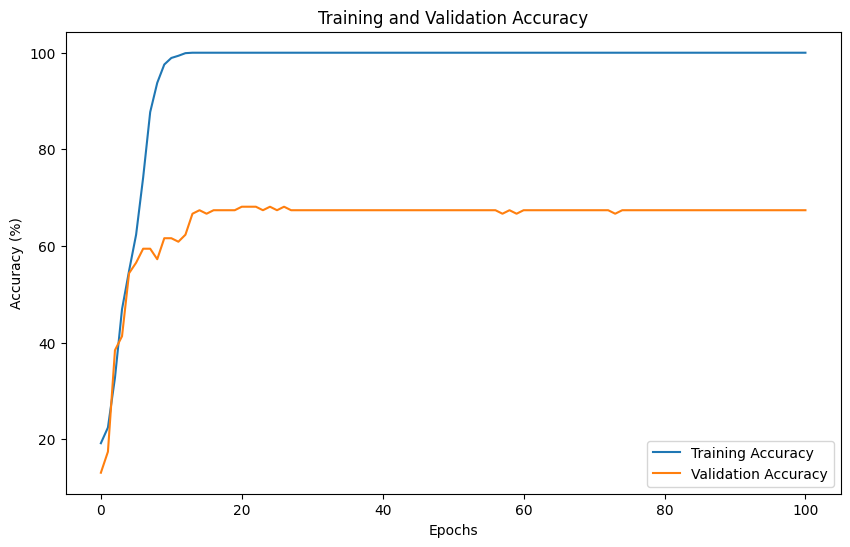

Test Accuracy: 65.47%
Test Loss averaged: 2.2034
Accuracy Variance: 34.8463

T-statistic: -3.7759079727016314, P-value: 0.019504612498143097
THERE IS a statistically significant difference.
Epoch [1/101], Train Acc: 17.98, Val Acc: 14.49
Epoch [11/101], Train Acc: 67.39, Val Acc: 56.52
Epoch [21/101], Train Acc: 83.92, Val Acc: 81.88
Epoch [31/101], Train Acc: 90.70, Val Acc: 72.46
Epoch [41/101], Train Acc: 93.32, Val Acc: 81.16
Epoch [51/101], Train Acc: 94.49, Val Acc: 81.16
Epoch [61/101], Train Acc: 97.02, Val Acc: 82.61
Epoch [71/101], Train Acc: 98.01, Val Acc: 85.51
Epoch [81/101], Train Acc: 98.46, Val Acc: 86.23
Epoch [91/101], Train Acc: 97.20, Val Acc: 84.78
Epoch [101/101], Train Acc: 98.19, Val Acc: 78.99
Best accuracy: 87.68


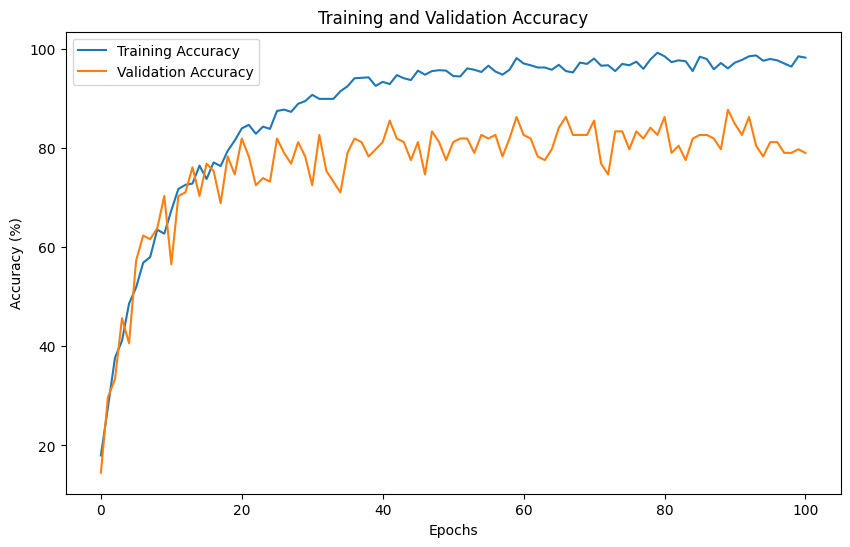

Test Accuracy: 85.61%
Test Loss averaged: 0.6544
Accuracy Variance: 50.7812

T-statistic: -5.051711822999671, P-value: 0.007222402498524441
THERE IS a statistically significant difference.


True

In [63]:
################### Task 2 ###################
from scipy.stats import ttest_rel
from torchvision import transforms
from scipy.stats import ttest_rel # build a function for statistical comparison

class RecipeCNN(nn.Module):
    def __init__(self, _num_classes):
        super(RecipeCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, _num_classes)

    def forward(self, _x):
        _x = self.pool1(F.relu(self.conv1(_x)))
        _x = self.pool2(F.relu(self.conv2(_x)))
        _x = self.pool3(F.relu(self.conv3(_x)))
        _x = _x.view(_x.size(0), -1) 
        _x = F.relu(self.fc1(_x))
        _x = F.relu(self.fc2(_x))
        _x = F.relu(self.fc3(_x))
        _x = self.fc4(_x)
        return _x

# """
x, y, _ = get_input(_permute=True) # permute dimensions
train_loader, val_loader, test_loader = get_loads(_x=x, _y=y)
model_cnn = RecipeCNN(len(label_to_idx)).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model_cnn.parameters())
train_acc, val_acc, best_model_cnn = train(
    model_cnn, CONFIGS["criterion"], optimizer, (train_loader, val_loader)
)
save_model(best_model_cnn, 'best_cnn.pth')
plot_accuracies(train_acc, val_acc)
metrics_cnn = evaluate_model(best_model_cnn, test_loader)
statistical_comparison(metrics_ffnn, metrics_cnn)

# """

#--------------------------------------------------------
# 6. apply image manipulation and augmentation techniques
#--------------------------------------------------------
# defining some transformations
augmentation_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),  # ensure images have correct input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


x, y, _ = get_input(_permute=True) # permute dimensions
train_loader, val_loader, test_loader = get_loads(_x=x, _y=y, _transform=augmentation_transforms)
model_cnn_aug = RecipeCNN(len(label_to_idx)).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model_cnn_aug.parameters())
train_acc, val_acc, best_model_cnn_aug = train(
    model_cnn_aug, CONFIGS["criterion"], optimizer, (train_loader, val_loader)
)
save_model(best_model_cnn_aug, 'best_cnn_aug.pth')
plot_accuracies(train_acc, val_acc)
metrics_cnn_aug = evaluate_model(best_model_cnn_aug, test_loader)
statistical_comparison(metrics_cnn, metrics_cnn_aug)

In [64]:
################### Task 2 BONUS ###################
from sklearn.model_selection import ParameterGrid

# define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'epochs': [CONFIGS["epochs"]]
}

# function to perform training and validation
def train_and_evaluate_model(_params):
    _x, _y, _ = get_input(_permute=True) # permute dimensions
    _train_loader, _val_loader, _test_loader = get_loads(_x=_x, _y=_y)
    _model_grid = RecipeCNN(len(label_to_idx)).to(CONFIGS["device"])
    _optimizer = torch.optim.Adam(_model_grid.parameters(), lr=_params['learning_rate'])
    _train_acc, _val_acc, _best_model_grid = train(
        _model_grid, CONFIGS["criterion"], _optimizer, (_train_loader, _val_loader), _epochs=_params['epochs']
    )
    _metrics_grid = evaluate_model(_best_model_grid, _test_loader)
    return _metrics_grid, _best_model_grid
    

# grid search execution
best_overall_metrics = None
best_overall_params = None
best_model_weights = None

for grid_params in ParameterGrid(param_grid):
    print(f"Testing with parameters: {grid_params}")
    metrics_grid, model_grid = train_and_evaluate_model(grid_params)
    print(f"Accuracy: {accuracy}")
    is_first_iteration = lambda: best_overall_metrics is None
    is_different_lazy = lambda: statistical_comparison(metrics_grid, best_overall_metrics)
    is_cur_model_better = lambda: is_different_lazy() and metrics_grid.accuracy > best_overall_metrics.accuracy
    
    if is_first_iteration() or is_cur_model_better():
        best_overall_metrics = metrics_grid
        best_overall_params = grid_params
        best_model_weights = model_grid.state_dict()

# output the best parameters and set the best model
print(f"Best Parameters: {best_overall_params}")
model_grid.load_state_dict(best_model_weights)
torch.save(model_grid.state_dict(), 'best_grid.pth')
statistical_comparison(metrics_cnn, best_overall_metrics)

Testing with parameters: {'batch_size': 32, 'epochs': 101, 'learning_rate': 0.001}
Epoch [1/101], Train Acc: 15.36, Val Acc: 21.01
Epoch [11/101], Train Acc: 99.64, Val Acc: 55.80
Epoch [21/101], Train Acc: 100.00, Val Acc: 64.49
Epoch [31/101], Train Acc: 100.00, Val Acc: 63.77
Epoch [41/101], Train Acc: 100.00, Val Acc: 63.04
Epoch [51/101], Train Acc: 100.00, Val Acc: 62.32
Epoch [61/101], Train Acc: 100.00, Val Acc: 62.32
Epoch [71/101], Train Acc: 100.00, Val Acc: 62.32
Epoch [81/101], Train Acc: 100.00, Val Acc: 62.32
Epoch [91/101], Train Acc: 100.00, Val Acc: 60.87
Epoch [101/101], Train Acc: 100.00, Val Acc: 60.87
Best accuracy: 67.39
Test Accuracy: 60.43%
Test Loss averaged: 2.6510
Accuracy Variance: 71.4941

Accuracy: 63.768115942028984
Testing with parameters: {'batch_size': 32, 'epochs': 101, 'learning_rate': 0.0001}
Epoch [1/101], Train Acc: 17.71, Val Acc: 16.67
Epoch [11/101], Train Acc: 74.35, Val Acc: 64.49
Epoch [21/101], Train Acc: 95.93, Val Acc: 63.04
Epoch [31/10

False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

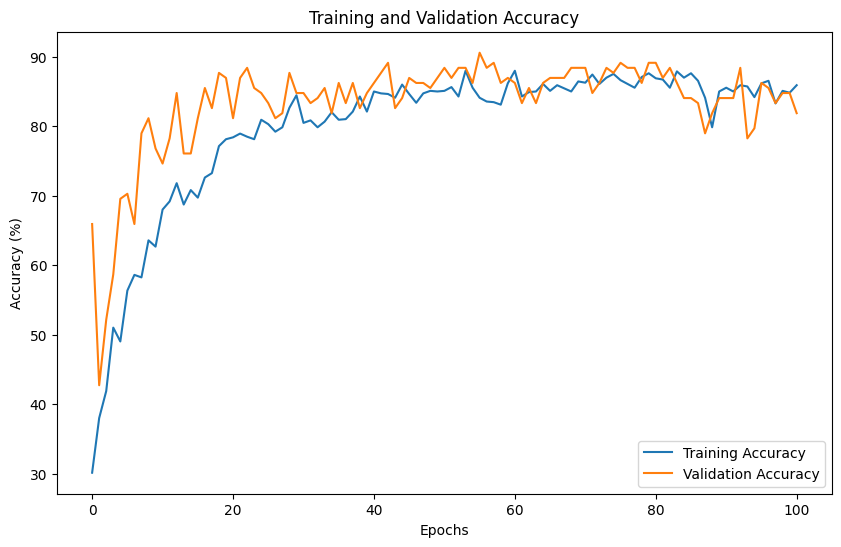

Test Accuracy: 87.77%
Test Loss averaged: 0.3520
Accuracy Variance: 5.7658

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 

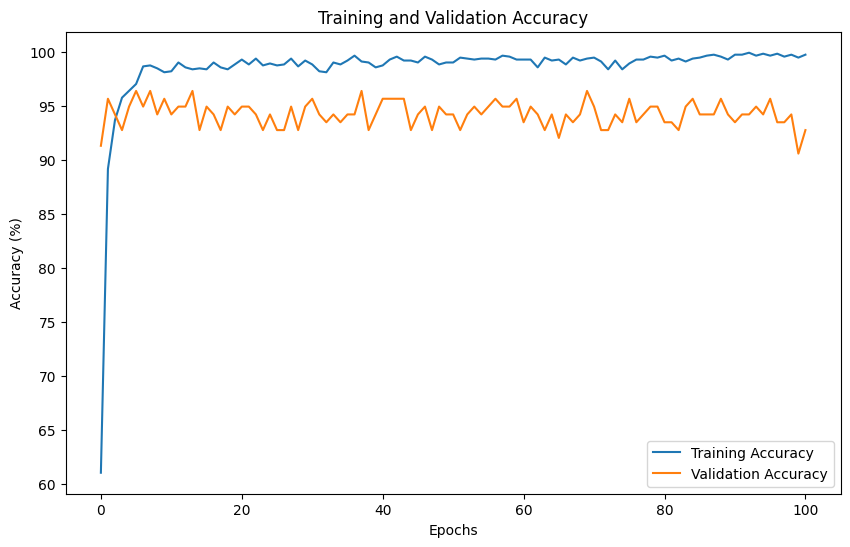

Test Accuracy: 95.68%
Test Loss averaged: 0.1116
Accuracy Variance: 13.2812

T-statistic: -3.8204357447506387, P-value: 0.018771278685039517
THERE IS a statistically significant difference.


True

In [65]:
################### Task 3 ###################
import torch.nn as nn
import torchvision.models as models

class CuttedModifiedVGG19(nn.Module):
    def __init__(self, num_classes, cut_point):
        super(CuttedModifiedVGG19, self).__init__()
        # Load the pre-trained VGG19 model
        vgg19 = models.vgg19(pretrained=True)
        # you can see the VGG19 detailed architecture
        #print(vgg19)
        # Extract the feature extractor part of VGG19 (all layers except the classifier)
        # TODO specify your cut layer
        self.cut_value = cut_point
        self.features =  nn.Sequential(*list(vgg19.features.children())[:self.cut_value]) #vgg19.features
        
        # check your new model based on the cut
        print(self.features)
        
       
        for param in self.features.parameters():
            param.requires_grad = False
            
        # TODO Initialize your layers
        # dummy input of a 224x224 with rgb (3 channels) to get flatten dimension
        dummy_input = torch.zeros(1, 3, 224, 224)
        #print("s1", dummy_input.shape)
        _flat_dimension = None
        with torch.no_grad():
            _output = self.features(dummy_input)
            _flat_dimension = _output.view(_output.size(0), -1).size(1)

        # additional classifier layers similar to VGG's Block 6
        self.classifiers = nn.Sequential(
            nn.Linear(_flat_dimension, 256),  # dimension depending on input size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # Pass input through VGG19 feature extractor
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten features
        x = self.classifiers(x)  # pass through classifier
        return x


# 1st block: 11th conv layer + associated pool, act func
# 2nd block: None by default picks all the layers of the VGG19 model
cuts = {1: 25, 2: None}

x, y, _ = get_input(_permute=True) # permute dimensions
train_loader, val_loader, test_loader = get_loads(_x=x, _y=y)
model_cut1 = CuttedModifiedVGG19(num_classes=len(label_to_idx), cut_point=cuts[1]).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model_cut1.classifiers.parameters()) 
train_acc, val_acc, best_model_cut1 = train(
    model_cut1, CONFIGS["criterion"], optimizer, (train_loader, val_loader)
)
save_model(best_model_cut1, 'best_cnn_cut1.pth')
plot_accuracies(train_acc, val_acc)
metrics_cut1 = evaluate_model(best_model_cut1, test_loader)

model_cut2 = CuttedModifiedVGG19(num_classes=len(label_to_idx), cut_point=cuts[2]).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model_cut2.classifiers.parameters()) # Only optimize classifier parameters
train_acc, val_acc, best_model_cut2 = train(model_cut2, CONFIGS["criterion"], optimizer, (train_loader, val_loader))
save_model(best_model_cut2, 'best_cnn_cut2.pth')
plot_accuracies(train_acc, val_acc)
metrics_cut2 = evaluate_model(best_model_cut2, test_loader)
statistical_comparison(metrics_cut1, metrics_cut2)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Epoch [1/101], Train Acc: 18.79, Val Acc: 15.22
Epoch [11/101], Train Acc: 16.08, Val Acc: 11.59
Epoch [21/101], Train Acc: 17.89, Val Acc: 11.59
Epoch [31/101], Train Acc: 18.16, Val Acc: 11.59
Epoch [41/101], Train Acc: 18.61, Val Acc: 11.59
Epoch [51/101], Train Acc: 18.07, Val Acc: 11.59
Epoch [61/101], Train Acc: 18.88, Val Acc: 11.59
Epoch [71/101], Train Acc: 17.25, Val Acc: 11.59
Epoch [81/101], Train Acc: 17.98, Val Acc: 11.59
Epoch [91/101], Train Acc: 17.98, Val Acc: 11.59
Epoch [101/101], Train Acc: 17.98, Val Acc: 11.59
Best accuracy: 15.22
Test Accuracy: 19.42%
Test Loss averaged: 1.7911
Accuracy Variance: 1.7562

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), pad

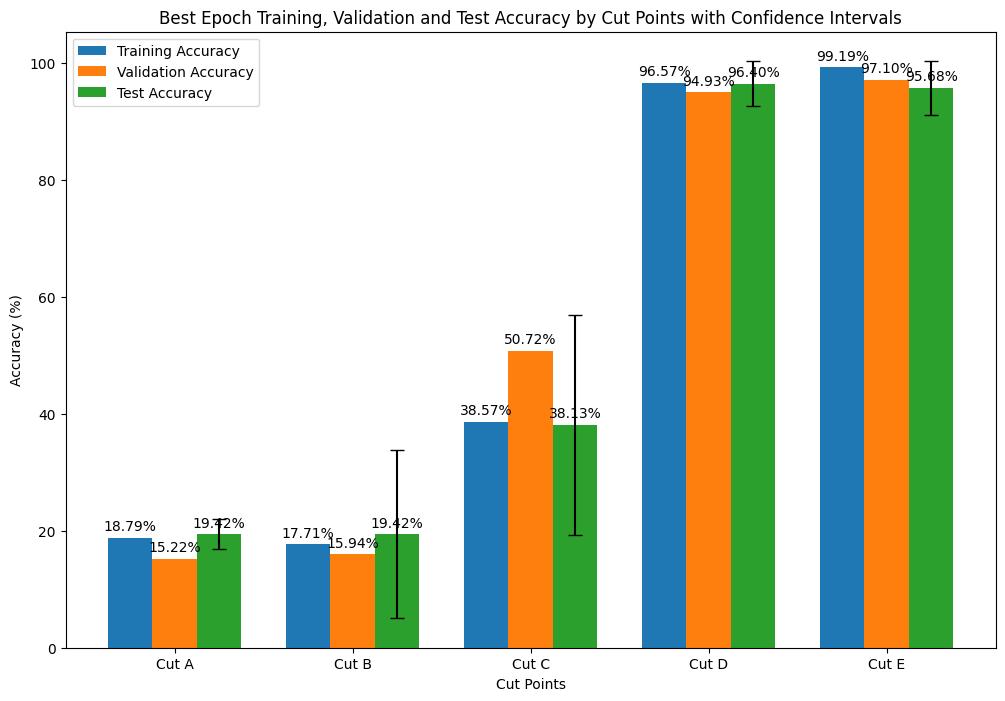

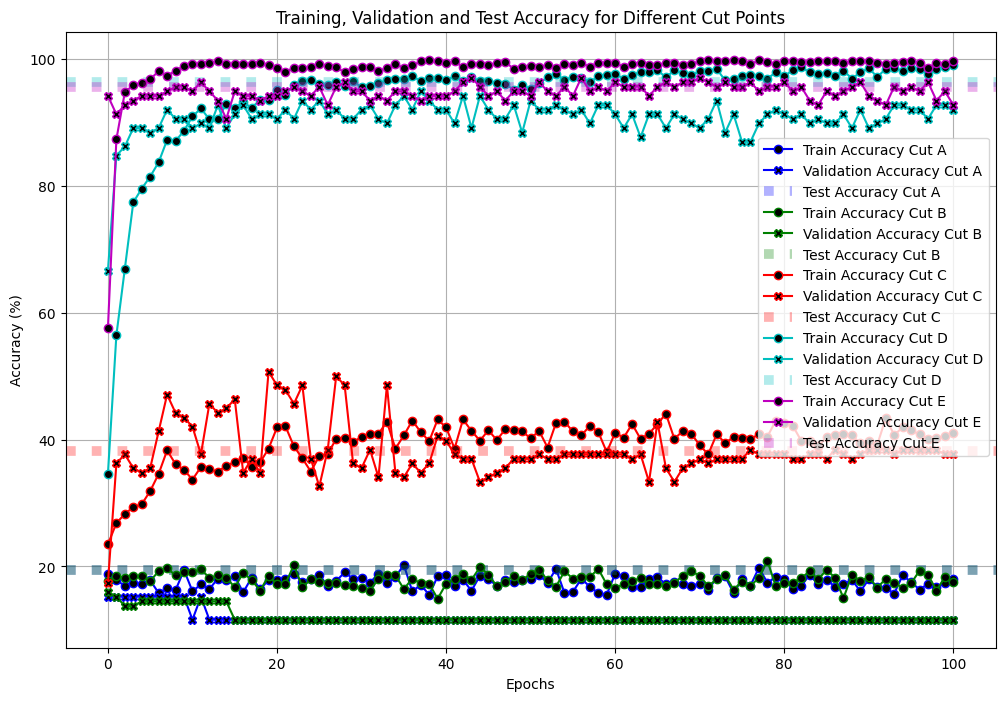

In [66]:
################### Task 3 Bonus ###################
from scipy.stats import norm
bonus_cuts = {
    'A': 5,   # end of first block
    'B': 10,  # end of second block
    'C': 19,  # end of third block
    'D': 28,  # end of fourth block
    'E': 37   # end of fifth block
}

val_acc_bonus = []
for cut_point in bonus_cuts.values():
    model_cut = CuttedModifiedVGG19(num_classes=len(label_to_idx), cut_point=cut_point).to(CONFIGS["device"])
    optimizer = CONFIGS["optimizer"](model_cut.classifiers.parameters())  
    train_acc, val_acc, best_model_cut = train(
        model_cut, CONFIGS["criterion"], optimizer, (train_loader, val_loader)
    )
    metrics_cut = evaluate_model(best_model_cut, test_loader)
    val_acc_bonus.append((train_acc, val_acc, metrics_cut))
    
train_accuracies, val_accuracies, test_metrics = zip(*val_acc_bonus)
# extract accuracies of the best epoch
best_val_accuracies = []
correspondent_train_accuracies = []
for i in range(len(bonus_cuts)):
    # index of max validation accuracy (early stopping model)
    max_index = val_accuracies[i].index(max(val_accuracies[i]))
    best_val_accuracies.append(val_accuracies[i][max_index]) # corresponding training accuracy
    correspondent_train_accuracies.append(train_accuracies[i][max_index])

list_test_accuracies = [metric.accuracy for metric in test_metrics]
accuracy_variances = [metric.accuracy_var for metric in test_metrics]
# calculate confidence intervals
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2)  # for 95% confidence interval
conf_intervals = [z_score * np.sqrt(variance) for variance in accuracy_variances]
# plot histogram
bar_width = 0.25
fig, ax = plt.subplots(figsize=(12, 8))
x_indices = np.arange(len(bonus_cuts))
bars1 = ax.bar(x_indices - bar_width, correspondent_train_accuracies, bar_width, label='Training Accuracy')
bars2 = ax.bar(x_indices, best_val_accuracies, bar_width, label='Validation Accuracy')
bars3 = ax.bar(x_indices + bar_width, list_test_accuracies, bar_width, yerr=conf_intervals, label='Test Accuracy', capsize=5)
ax.set_xlabel('Cut Points')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Best Epoch Training, Validation and Test Accuracy by Cut Points with Confidence Intervals')
ax.set_xticks(x_indices)
ax.set_xticklabels([f'Cut {i}' for i in bonus_cuts.keys()])
ax.legend()

# add labels on the top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
plt.show()

# PLOT WITH ALL CUTS
train_accuracies_np = np.array(train_accuracies)
val_accuracies_np = np.array(val_accuracies)

# plotting accuracy lines
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm']  # colors foreach cut
for i, (cut_label, cut_point) in enumerate(bonus_cuts.items()):
    color = colors[i % len(colors)]  # color selection
    plt.plot(
        train_accuracies_np[i], 
        label=f'Train Accuracy Cut {cut_label}', 
        marker='o', 
        markerfacecolor='black',
        color=color
    )
    
    plt.plot(
        val_accuracies_np[i], 
        label=f'Validation Accuracy Cut {cut_label}', 
        linestyle='-', 
        marker='X',
        markerfacecolor='black',
        color=color
    )
    
    # bolded colored line for test accuracy indicator
    plt.axhline(y=test_metrics[i].accuracy, 
                label=f'Test Accuracy Cut {cut_label}', 
                color=color, 
                linestyle=':', 
                linewidth=7,
                alpha=0.3
    )


# adding labels, title and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation and Test Accuracy for Different Cut Points')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.3, 0.5, 0.5))
plt.grid(True)
plt.show()